**Table of contents**<a id='toc0_'></a>    
- [Research And Goal:](#toc1_1_1_)    
      - [The national income or product identity vs Interest Rate](#toc1_1_1_1_)    
      - [Data Source](#toc1_1_1_2_)    
    - [dataset merge function](#toc1_1_2_)    
    - [Combinining Dataset](#toc1_1_3_)    
      - [Create Dataset from Dollar Price Index](#toc1_1_3_1_)    
      - [Replace non-numberic values to NaN](#toc1_1_3_2_)    
      - [show heatmap for NaN values](#toc1_1_3_3_)    
  - [cleaning up dateset](#toc1_2_)    
      - [Drop Rows which value NaN in data](#toc1_2_1_1_)    
      - [Fill NaN](#toc1_2_1_2_)    
    - [Sort and inverse DataFrame](#toc1_2_2_)    
    - [Export Dataset to single CSV File](#toc1_2_3_)    
    - [Plot values](#toc1_2_4_)    
    - [Drop index/periodDateUTC value](#toc1_2_5_)    
    - [check simple correlation between features and Interest Rate](#toc1_2_6_)    
    - [check for correlation between all features](#toc1_2_7_)    
      - [find most correlted feature](#toc1_2_7_1_)    
      - [Variance Inflation Factor (VIF)](#toc1_2_7_2_)    
    - [Feature Selection](#toc1_2_8_)    
      - [Combine Feature which are highly correlated with each other from above figure](#toc1_2_8_1_)    
    - [Spliting data](#toc1_2_9_)    
    - [Bios Calculation](#toc1_2_10_)    
    - [Linear Regression](#toc1_2_11_)    
    - [Multivariate Normality and Homoscedasticity](#toc1_2_12_)    
    - [r2 score and mean squared error](#toc1_2_13_)    
    - [SVR (Support Vector Regression)](#toc1_2_14_)    
    - [Accuracy of SVR](#toc1_2_15_)    
    - [Random Forest Regression:](#toc1_2_16_)    
        - [Accuracy of RFR](#toc1_2_16_1_1_)    
    - [Confusion Matrix](#toc1_2_17_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Research And Goal:](#toc0_)

#### <a id='toc1_1_1_1_'></a>[The national income or product identity vs Interest Rate](#toc0_)

The two most frequently cited indexes that calculate the inflation rate in the U.S. are the Consumer Price Index (CPI) and the Personal Consumption Expenditures Price Index (PCE). These two measures take different approaches to measuring and calculating inflation.

The national income or product identity describes the way in which the gross domestic product (GDP) is measured, as the sum of expenditures in various broad spending categories.
</br>

<b>what is an open economy ?</b></br>
An open economy refers to an economy where people and businesses can freely trade in goods and services with other countries. 
</br>



<b>Total Manufacturing Cost – What is it and How to Calculate it?</b> </br>
Total manufacturing cost is an essential metric for understanding the profitability of a business. It can be used to adjust the selling price of your products, identify and cut expenses, and calculate other key metrics like the Cost of Goods Manufactured.</br>

<b><i>
Total Manufacturing Cost = Direct Materials + Direct Labor + Manufacturing Overhead
</i></b>

<b>All Employees, Total Nonfarm: </b> This data provides insights into the overall employment situation. A strong increase in total nonfarm employment could indicate a growing economy, potentially leading to increased borrowing and spending. If the economy is overheating, central banks might respond by raising interest rates to prevent excessive inflation.

Consumer Price Index (CPI) - All Items and Urban Consumers: CPI measures inflation and rising prices. Higher inflation might lead central banks to raise interest rates to control inflationary pressures. Conversely, if CPI is low, central banks might lower rates to stimulate spending and investment.

Labor Force Participation Rate - Male: Changes in labor force participation can impact the overall employment rate and potential economic growth. A declining participation rate might signal structural issues in the labor market, affecting interest rate decisions.

Personal Consumption Expenditures (PCE): PCE is a measure of consumer spending. Strong consumer spending can stimulate economic growth, potentially leading to higher interest rates if the economy approaches full capacity.

Personal Income, Personal Interest Payments, Personal Saving Rate: These indicators can collectively provide insights into household financial health. High personal interest payments relative to income and savings might indicate a potential strain on households, affecting their ability to borrow and spend, which can influence interest rate decisions.

Population and Working Age Population: Demographic changes, such as an aging population or shifts in the working-age population, can impact overall economic growth potential. These changes might influence interest rate decisions, especially if they affect long-term growth prospects.

Producer Price Index (PPI) - Total Manufacturing Industries and PPI by Commodity - All Commodities: These indicators measure changes in producer prices. Rising producer prices can lead to higher costs for businesses, potentially affecting profit margins and leading to interest rate decisions.

Unemployment Rate: A high unemployment rate might prompt central banks to lower interest rates to stimulate economic activity and job creation. Conversely, a very low unemployment rate might lead to higher interest rates to prevent overheating.

University of Michigan - Inflation Expectation: Market expectations of future inflation can influence interest rates. If inflation expectations are rising, central banks might respond by raising rates to control inflation.

Personal Interest Payments: High levels of personal interest payments might lead to reduced disposable income and consumer spending, affecting overall economic growth and interest rate decisions.

#### <a id='toc1_1_1_2_'></a>[Data Source](#toc0_)

Data Source For Features: <a href ="https://fred.stlouisfed.org">Federal Reserve Bank of St. Louis, One Federal Reserve Bank Plaza, St. Louis</a></br>
Data Source for USD Index: <a href ="https://finance.yahoo.com/quote/DX-Y.NYB/history?period1=31795200&period2=1691884800&interval=1mo&filter=history&frequency=1mo&includeAdjustedClose=true">Yahoo Finance</a>

In [591]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

from collections import Counter
from sklearn.metrics import mean_squared_error, mean_absolute_error

### <a id='toc1_1_2_'></a>[dataset merge function](#toc0_)

In [592]:
def combinedDF(main_df, df, name):

    #rename values of new data
    df.columns.values[1] = name

    if 'DATE' not in main_df.columns: 
        print("Date Doesn't exist.")
        return df.copy()

    # Convert to datetime
    main_df['DATE'] = pd.to_datetime(main_df['DATE'], utc=True)
    df['DATE'] = pd.to_datetime(df['DATE'], utc=True)

    # Calculate time-based features
    main_df['year'] = main_df['DATE'].dt.year
    main_df['month'] = main_df['DATE'].dt.month
    df['year'] = df['DATE'].dt.year
    df['month'] = df['DATE'].dt.month

    # Merge the two dataframes
    merged_df = main_df.merge(df, on=['year', 'month'], how='inner')

    # Assign the 'periodDateUtc_y' values to 'periodDateUtc' column
    merged_df['DATE'] = merged_df['DATE_y']

    # Drop unnecessary columns
    merged_df.drop(columns=['DATE_x', 'DATE_y'], inplace=True)

    merged_df.sort_values(by='DATE', inplace=True)
    # Reset the index if needed
    merged_df.reset_index(drop=True, inplace=True)
    
    return merged_df

### <a id='toc1_1_3_'></a>[Combinining Dataset](#toc0_)

#### <a id='toc1_1_3_1_'></a>[Create Dataset from Dollar Price Index](#toc0_)
<i> Note: It's created Seperately because It's different from all other datasets </i>

In [593]:
dollar_index = pd.read_csv("./new_data/Price/Dollar Price Index.csv")

data = pd.DataFrame()
data["DATE"] = dollar_index["Date"]
data["Dollar Price Index"] = dollar_index["Close"]

EURUSD_i = pd.read_csv("./new_data/Price/EURUSD.csv")
EURUSD = pd.DataFrame()
EURUSD["DATE"] = EURUSD_i["Date"]
EURUSD["EURUSD"] = EURUSD_i["Close"]

data = combinedDF(data, EURUSD, "EURUSD")

NASDAQ_i = pd.read_csv("./new_data/Price/NASDAQ Composite.csv")
NASDAQ = pd.DataFrame()
NASDAQ["DATE"] = NASDAQ_i["Date"]
NASDAQ["EURUSD"] = NASDAQ_i["Close"]

data = combinedDF(data, NASDAQ, "NASDAQ Composite")

data

,Dollar Price Index,year,month,EURUSD,NASDAQ Composite,DATE
0,86.919998,2003,12,1.259002,2003.369995,2003-12-01 00:00:00+00:00
1,87.199997,2004,1,1.245206,2066.149902,2004-01-01 00:00:00+00:00
2,87.309998,2004,2,1.253007,2029.819946,2004-02-01 00:00:00+00:00
3,87.610001,2004,3,1.231300,1994.219971,2004-03-01 00:00:00+00:00
4,90.480003,2004,4,1.198294,1920.150024,2004-04-01 00:00:00+00:00
...,...,...,...,...,...,...
239,102.852997,2023,8,1.094931,13644.849609,2023-08-01 00:00:00+00:00
240,102.839996,2023,8,1.098165,13644.849609,2023-08-11 00:00:00+00:00
241,102.852997,2023,8,1.098165,13644.849609,2023-08-11 00:00:00+00:00
242,102.839996,2023,8,1.094931,13644.849609,2023-08-11 00:00:00+00:00


In [594]:
# Folder containing CSV files
folder_path = './new_data/Features/'

# Get a list of CSV files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# Create a dictionary to store DataFrames
dataframes_dict = {}

# Read each CSV file and store it in the dictionary with the filename as key
for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    df = pd.read_csv(file_path)
    dataframes_dict[csv_file] = df

# Print the keys (file names) and the corresponding DataFrames
for filename, df in dataframes_dict.items():
    print(f"File: {filename}")
    data = combinedDF(data,df,filename.replace('.csv', ''))
    
data.head(20)

File: All Employees, Total Nonfarm.csv
File: Consumer Price Index - All Items.csv
File: Consumer Price Index - Urban Consumers.csv
File: Federal Funds Effective Rate - Interest Rate.csv
File: Labor force participation rate - Male.csv
File: Personal Consumption Expenditures.csv
File: Personal Income.csv
File: Personal interest payments.csv
File: Personal Saving Rate.csv
File: Population.csv
File: Producer Price Index - Total Manufacturing Industries.csv
File: Producer Price Index by Commodity - All Commodities.csv
File: Unemployment Rate.csv
File: University of Michigan - Inflation Expectation.csv
File: Working Age Population.csv


,Dollar Price Index,year,month,EURUSD,NASDAQ Composite,"All Employees, Total Nonfarm",Consumer Price Index - All Items,Consumer Price Index - Urban Consumers,Federal Funds Effective Rate - Interest Rate,Labor force participation rate - Male,...,Personal Income,Personal interest payments,Personal Saving Rate,Population,Producer Price Index - Total Manufacturing Industries,Producer Price Index by Commodity - All Commodities,Unemployment Rate,University of Michigan - Inflation Expectation,Working Age Population,DATE
0,86.919998,2003,12,1.259002,2003.369995,130595,77.758135,185.5,0.98,90.7,...,9734.9,200.3,5.2,291868.0,137.7,139.5,5.7,2.6,1.881341e+08,2003-12-01 00:00:00+00:00
1,87.199997,2004,1,1.245206,2066.149902,130765,78.137855,186.3,1.00,90.7,...,9753.2,201.7,4.9,292046.0,138.9,141.4,5.7,2.7,1.876868e+08,2004-01-01 00:00:00+00:00
2,87.309998,2004,2,1.253007,2029.819946,130822,78.559766,186.7,1.01,90.4,...,9786.7,201.0,4.9,292230.0,139.3,142.1,5.6,2.6,1.878746e+08,2004-02-01 00:00:00+00:00
3,87.610001,2004,3,1.231300,1994.219971,131139,79.066059,187.1,1.00,90.2,...,9837.2,198.8,4.7,292434.0,140.3,143.1,5.8,2.9,1.880565e+08,2004-03-01 00:00:00+00:00
4,90.480003,2004,4,1.198294,1920.150024,131410,79.319205,187.4,1.00,90.3,...,9887.5,200.9,5.1,292651.0,141.8,144.8,5.6,3.2,1.883187e+08,2004-04-01 00:00:00+00:00
5,88.949997,2004,5,1.219899,1986.739990,131694,79.783307,188.2,1.00,90.5,...,9972.9,202.9,5.1,292872.0,143.3,146.8,5.6,3.3,1.884768e+08,2004-05-01 00:00:00+00:00
6,88.800003,2004,6,1.218398,2047.790039,131789,80.036453,188.9,1.03,90.5,...,10013.0,204.5,5.6,293103.0,142.9,147.2,5.6,3.3,1.886889e+08,2004-06-01 00:00:00+00:00
7,89.959999,2004,7,1.201605,1887.359985,131849,79.909880,189.1,1.26,90.7,...,10060.0,205.6,5.0,293350.0,143.2,147.4,5.5,3.0,1.888416e+08,2004-07-01 00:00:00+00:00
8,88.940002,2004,8,1.217804,1838.099976,131936,79.952071,189.2,1.43,90.5,...,10107.8,207.7,5.0,293603.0,143.7,148.0,5.4,2.8,1.890726e+08,2004-08-01 00:00:00+00:00
9,87.360001,2004,9,1.243394,1896.839966,132082,80.120835,189.8,1.61,90.4,...,10142.9,210.3,4.4,293857.0,144.2,147.7,5.4,2.8,1.892184e+08,2004-09-01 00:00:00+00:00


#### <a id='toc1_1_3_2_'></a>[Replace non-numberic values to NaN](#toc0_)

->  get date values since it's non-numberic but it's needed later
anc combine it later

In [595]:

date_values = data['DATE'].copy()

# Apply the function to each element of the DataFrame
data = data.apply(pd.to_numeric, errors='coerce')

data['DATE'] = date_values

data.head(20)

,Dollar Price Index,year,month,EURUSD,NASDAQ Composite,"All Employees, Total Nonfarm",Consumer Price Index - All Items,Consumer Price Index - Urban Consumers,Federal Funds Effective Rate - Interest Rate,Labor force participation rate - Male,...,Personal Income,Personal interest payments,Personal Saving Rate,Population,Producer Price Index - Total Manufacturing Industries,Producer Price Index by Commodity - All Commodities,Unemployment Rate,University of Michigan - Inflation Expectation,Working Age Population,DATE
0,86.919998,2003,12,1.259002,2003.369995,130595,77.758135,185.5,0.98,90.7,...,9734.9,200.3,5.2,291868.0,137.7,139.5,5.7,2.6,1.881341e+08,2003-12-01 00:00:00+00:00
1,87.199997,2004,1,1.245206,2066.149902,130765,78.137855,186.3,1.00,90.7,...,9753.2,201.7,4.9,292046.0,138.9,141.4,5.7,2.7,1.876868e+08,2004-01-01 00:00:00+00:00
2,87.309998,2004,2,1.253007,2029.819946,130822,78.559766,186.7,1.01,90.4,...,9786.7,201.0,4.9,292230.0,139.3,142.1,5.6,2.6,1.878746e+08,2004-02-01 00:00:00+00:00
3,87.610001,2004,3,1.231300,1994.219971,131139,79.066059,187.1,1.00,90.2,...,9837.2,198.8,4.7,292434.0,140.3,143.1,5.8,2.9,1.880565e+08,2004-03-01 00:00:00+00:00
4,90.480003,2004,4,1.198294,1920.150024,131410,79.319205,187.4,1.00,90.3,...,9887.5,200.9,5.1,292651.0,141.8,144.8,5.6,3.2,1.883187e+08,2004-04-01 00:00:00+00:00
5,88.949997,2004,5,1.219899,1986.739990,131694,79.783307,188.2,1.00,90.5,...,9972.9,202.9,5.1,292872.0,143.3,146.8,5.6,3.3,1.884768e+08,2004-05-01 00:00:00+00:00
6,88.800003,2004,6,1.218398,2047.790039,131789,80.036453,188.9,1.03,90.5,...,10013.0,204.5,5.6,293103.0,142.9,147.2,5.6,3.3,1.886889e+08,2004-06-01 00:00:00+00:00
7,89.959999,2004,7,1.201605,1887.359985,131849,79.909880,189.1,1.26,90.7,...,10060.0,205.6,5.0,293350.0,143.2,147.4,5.5,3.0,1.888416e+08,2004-07-01 00:00:00+00:00
8,88.940002,2004,8,1.217804,1838.099976,131936,79.952071,189.2,1.43,90.5,...,10107.8,207.7,5.0,293603.0,143.7,148.0,5.4,2.8,1.890726e+08,2004-08-01 00:00:00+00:00
9,87.360001,2004,9,1.243394,1896.839966,132082,80.120835,189.8,1.61,90.4,...,10142.9,210.3,4.4,293857.0,144.2,147.7,5.4,2.8,1.892184e+08,2004-09-01 00:00:00+00:00


#### <a id='toc1_1_3_3_'></a>[show heatmap for NaN values](#toc0_)

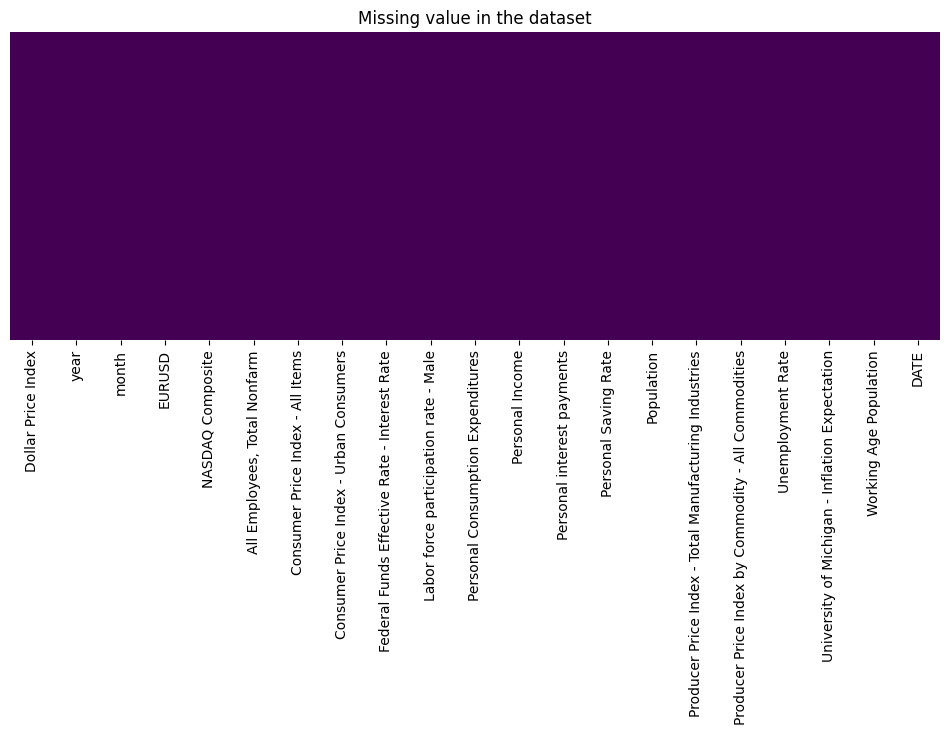

In [596]:
plt.figure(figsize=(12,4))
sns.heatmap(data.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing value in the dataset');

## <a id='toc1_2_'></a>[cleaning up dateset](#toc0_)

#### <a id='toc1_2_1_1_'></a>[Drop Rows which value NaN in data](#toc0_)
Nan Dates are not useful because it's doesn't represent anything

In [597]:
#remove data i fperiodDataUTC is null
data = data.dropna(subset=['DATE']);

#### <a id='toc1_2_1_2_'></a>[Fill NaN](#toc0_)
Fill NaN with previous values if there are any. In case there are not any previous values, we will replace it with zero. </br>

<i>Note: We will not replace non-previous values with avaerage beacause most of the values are in trend line (i.e. incremental) and average doesn't represent the correct value at any given point</i>

In [598]:
#first fill previous value if there is not a previous value fill 0
for column in data.columns:
    data[column].fillna(method="ffill", inplace=True)
    data[column].fillna(0, inplace=True)
    
data.head(10)

,Dollar Price Index,year,month,EURUSD,NASDAQ Composite,"All Employees, Total Nonfarm",Consumer Price Index - All Items,Consumer Price Index - Urban Consumers,Federal Funds Effective Rate - Interest Rate,Labor force participation rate - Male,...,Personal Income,Personal interest payments,Personal Saving Rate,Population,Producer Price Index - Total Manufacturing Industries,Producer Price Index by Commodity - All Commodities,Unemployment Rate,University of Michigan - Inflation Expectation,Working Age Population,DATE
0,86.919998,2003,12,1.259002,2003.369995,130595,77.758135,185.5,0.98,90.7,...,9734.9,200.3,5.2,291868.0,137.7,139.5,5.7,2.6,1.881341e+08,2003-12-01 00:00:00+00:00
1,87.199997,2004,1,1.245206,2066.149902,130765,78.137855,186.3,1.00,90.7,...,9753.2,201.7,4.9,292046.0,138.9,141.4,5.7,2.7,1.876868e+08,2004-01-01 00:00:00+00:00
2,87.309998,2004,2,1.253007,2029.819946,130822,78.559766,186.7,1.01,90.4,...,9786.7,201.0,4.9,292230.0,139.3,142.1,5.6,2.6,1.878746e+08,2004-02-01 00:00:00+00:00
3,87.610001,2004,3,1.231300,1994.219971,131139,79.066059,187.1,1.00,90.2,...,9837.2,198.8,4.7,292434.0,140.3,143.1,5.8,2.9,1.880565e+08,2004-03-01 00:00:00+00:00
4,90.480003,2004,4,1.198294,1920.150024,131410,79.319205,187.4,1.00,90.3,...,9887.5,200.9,5.1,292651.0,141.8,144.8,5.6,3.2,1.883187e+08,2004-04-01 00:00:00+00:00
5,88.949997,2004,5,1.219899,1986.739990,131694,79.783307,188.2,1.00,90.5,...,9972.9,202.9,5.1,292872.0,143.3,146.8,5.6,3.3,1.884768e+08,2004-05-01 00:00:00+00:00
6,88.800003,2004,6,1.218398,2047.790039,131789,80.036453,188.9,1.03,90.5,...,10013.0,204.5,5.6,293103.0,142.9,147.2,5.6,3.3,1.886889e+08,2004-06-01 00:00:00+00:00
7,89.959999,2004,7,1.201605,1887.359985,131849,79.909880,189.1,1.26,90.7,...,10060.0,205.6,5.0,293350.0,143.2,147.4,5.5,3.0,1.888416e+08,2004-07-01 00:00:00+00:00
8,88.940002,2004,8,1.217804,1838.099976,131936,79.952071,189.2,1.43,90.5,...,10107.8,207.7,5.0,293603.0,143.7,148.0,5.4,2.8,1.890726e+08,2004-08-01 00:00:00+00:00
9,87.360001,2004,9,1.243394,1896.839966,132082,80.120835,189.8,1.61,90.4,...,10142.9,210.3,4.4,293857.0,144.2,147.7,5.4,2.8,1.892184e+08,2004-09-01 00:00:00+00:00


### <a id='toc1_2_2_'></a>[Sort and inverse DataFrame](#toc0_)

Order of ```date``` is most important expect of data, so it's will be sorted by date in decremental order to create modal of old data first.

In [599]:
# Reverse the order of the DataFrame to make it descending
data = data.iloc[::-1]

# Sort the DataFrame by 'DATE' in ascending order
data.sort_values(by='DATE', inplace=True)

# Reset the index if needed
data.reset_index(drop=True, inplace=True)

data.head(10)

,Dollar Price Index,year,month,EURUSD,NASDAQ Composite,"All Employees, Total Nonfarm",Consumer Price Index - All Items,Consumer Price Index - Urban Consumers,Federal Funds Effective Rate - Interest Rate,Labor force participation rate - Male,...,Personal Income,Personal interest payments,Personal Saving Rate,Population,Producer Price Index - Total Manufacturing Industries,Producer Price Index by Commodity - All Commodities,Unemployment Rate,University of Michigan - Inflation Expectation,Working Age Population,DATE
0,86.919998,2003,12,1.259002,2003.369995,130595,77.758135,185.5,0.98,90.7,...,9734.9,200.3,5.2,291868.0,137.7,139.5,5.7,2.6,1.881341e+08,2003-12-01 00:00:00+00:00
1,87.199997,2004,1,1.245206,2066.149902,130765,78.137855,186.3,1.00,90.7,...,9753.2,201.7,4.9,292046.0,138.9,141.4,5.7,2.7,1.876868e+08,2004-01-01 00:00:00+00:00
2,87.309998,2004,2,1.253007,2029.819946,130822,78.559766,186.7,1.01,90.4,...,9786.7,201.0,4.9,292230.0,139.3,142.1,5.6,2.6,1.878746e+08,2004-02-01 00:00:00+00:00
3,87.610001,2004,3,1.231300,1994.219971,131139,79.066059,187.1,1.00,90.2,...,9837.2,198.8,4.7,292434.0,140.3,143.1,5.8,2.9,1.880565e+08,2004-03-01 00:00:00+00:00
4,90.480003,2004,4,1.198294,1920.150024,131410,79.319205,187.4,1.00,90.3,...,9887.5,200.9,5.1,292651.0,141.8,144.8,5.6,3.2,1.883187e+08,2004-04-01 00:00:00+00:00
5,88.949997,2004,5,1.219899,1986.739990,131694,79.783307,188.2,1.00,90.5,...,9972.9,202.9,5.1,292872.0,143.3,146.8,5.6,3.3,1.884768e+08,2004-05-01 00:00:00+00:00
6,88.800003,2004,6,1.218398,2047.790039,131789,80.036453,188.9,1.03,90.5,...,10013.0,204.5,5.6,293103.0,142.9,147.2,5.6,3.3,1.886889e+08,2004-06-01 00:00:00+00:00
7,89.959999,2004,7,1.201605,1887.359985,131849,79.909880,189.1,1.26,90.7,...,10060.0,205.6,5.0,293350.0,143.2,147.4,5.5,3.0,1.888416e+08,2004-07-01 00:00:00+00:00
8,88.940002,2004,8,1.217804,1838.099976,131936,79.952071,189.2,1.43,90.5,...,10107.8,207.7,5.0,293603.0,143.7,148.0,5.4,2.8,1.890726e+08,2004-08-01 00:00:00+00:00
9,87.360001,2004,9,1.243394,1896.839966,132082,80.120835,189.8,1.61,90.4,...,10142.9,210.3,4.4,293857.0,144.2,147.7,5.4,2.8,1.892184e+08,2004-09-01 00:00:00+00:00


### <a id='toc1_2_3_'></a>[Export Dataset to single CSV File](#toc0_)

In [600]:
# Export DataFrame to CSV file
csv_filename = './data.csv'
data.to_csv(csv_filename, index=False)

### <a id='toc1_2_4_'></a>[Plot values](#toc0_)

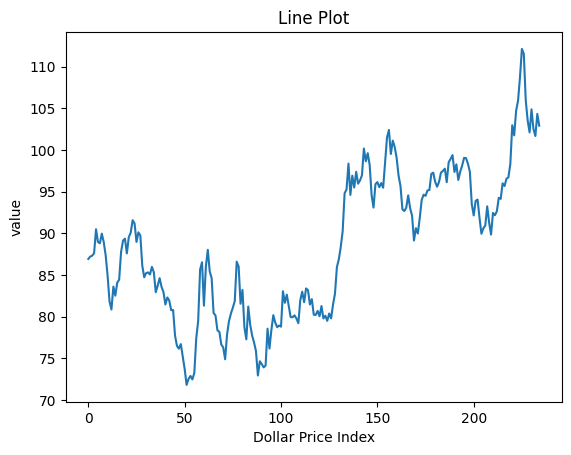

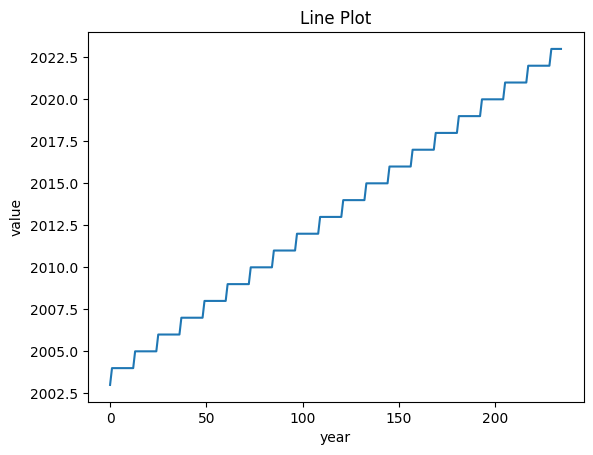

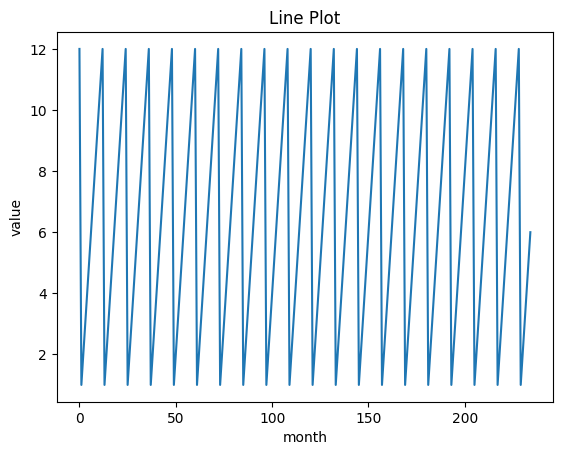

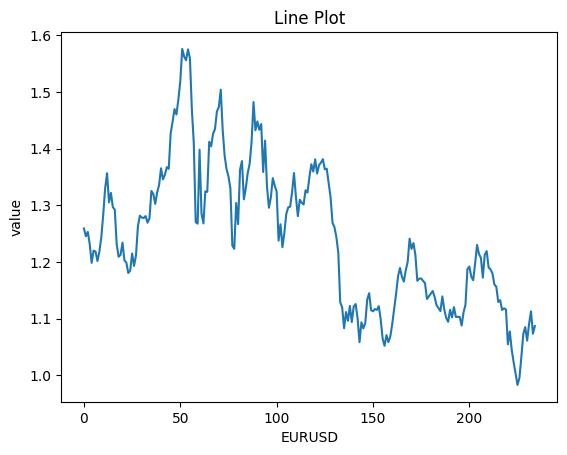

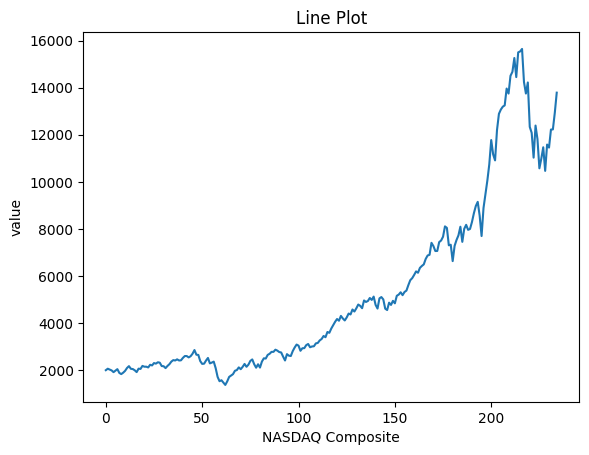

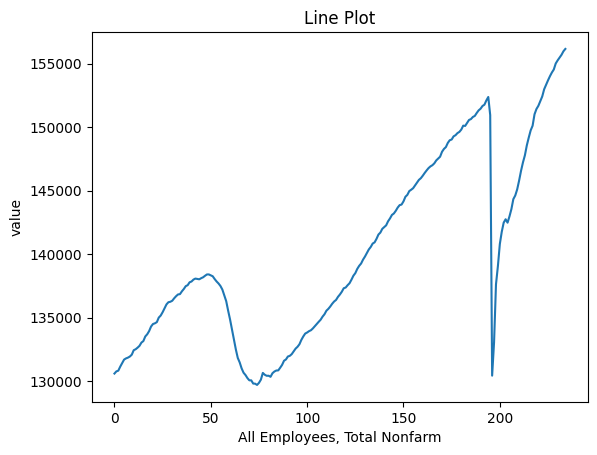

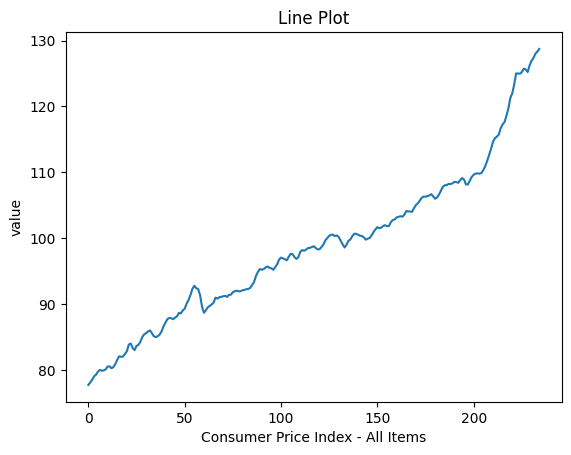

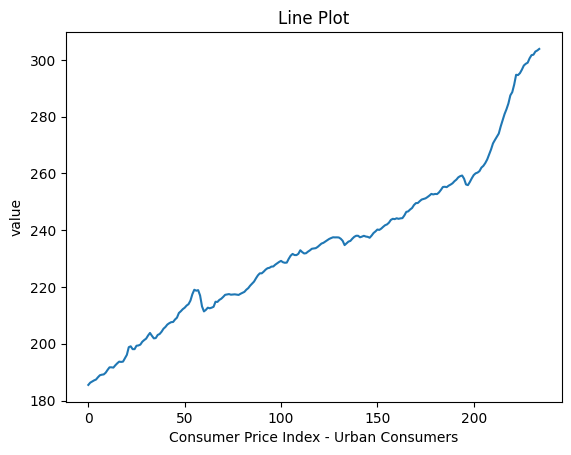

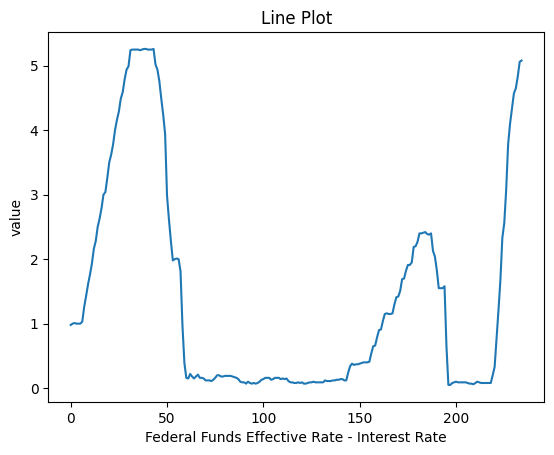

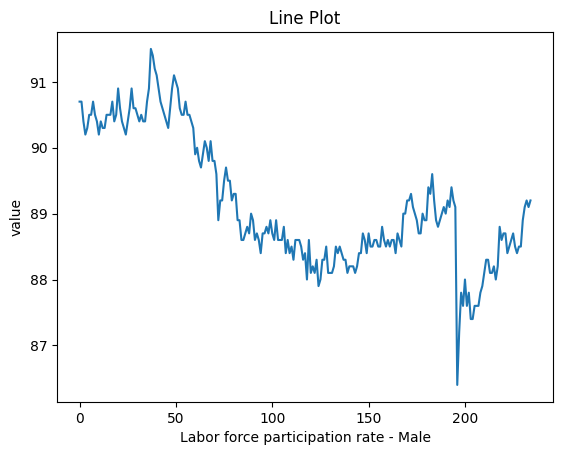

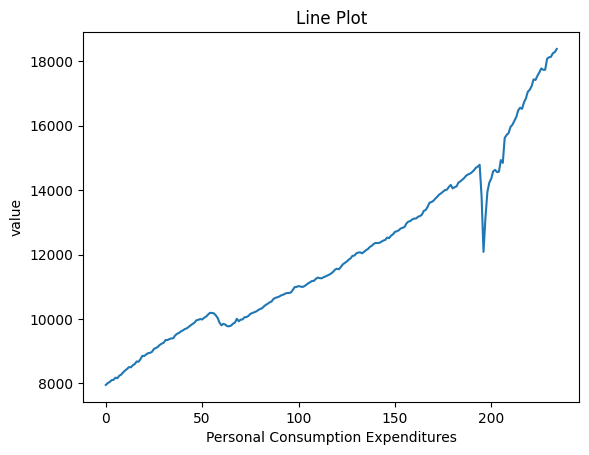

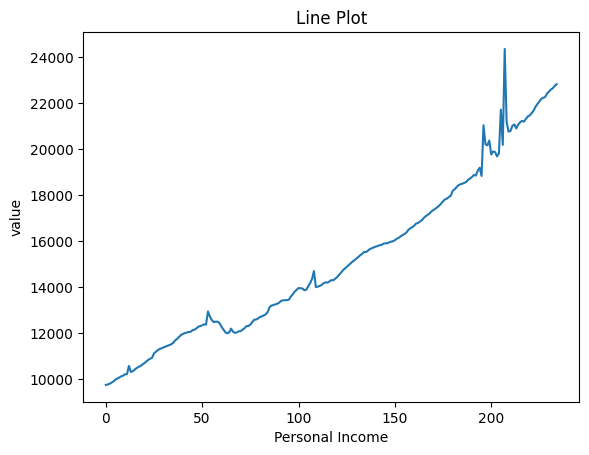

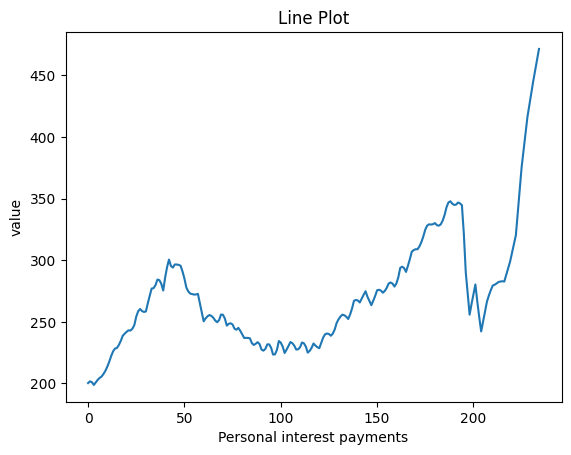

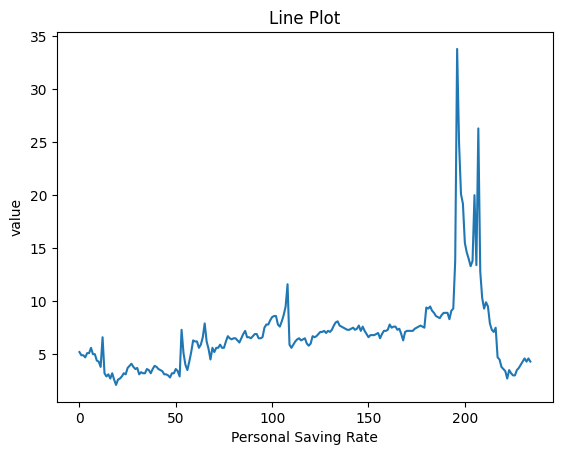

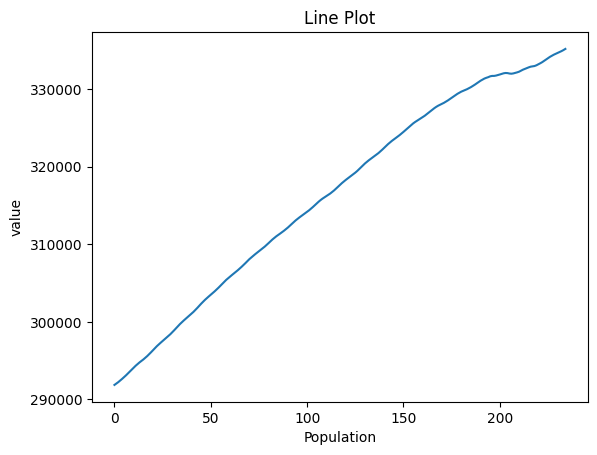

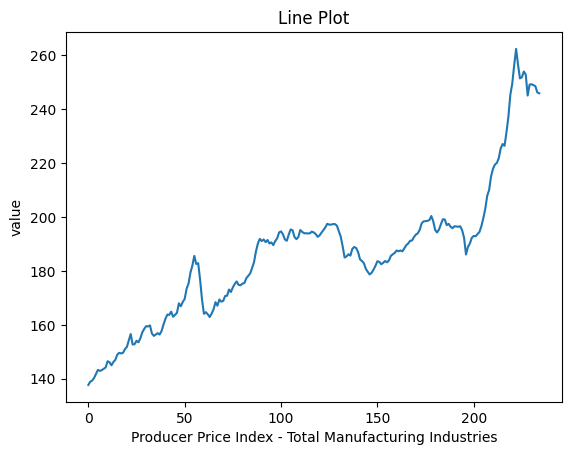

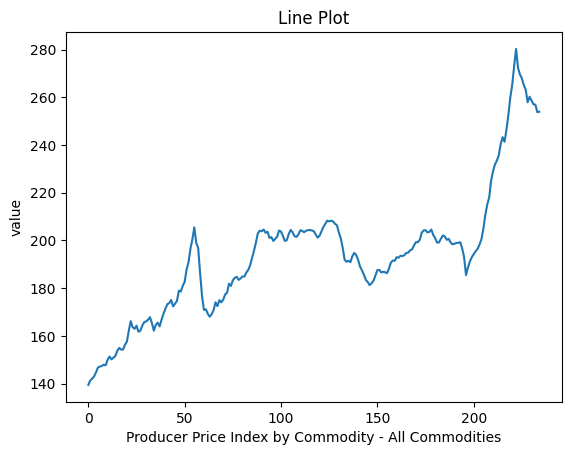

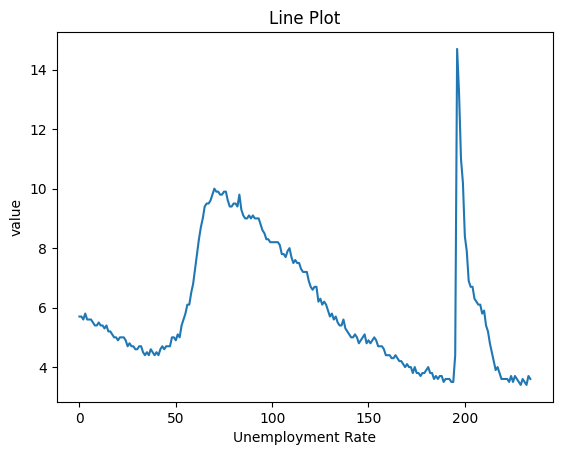

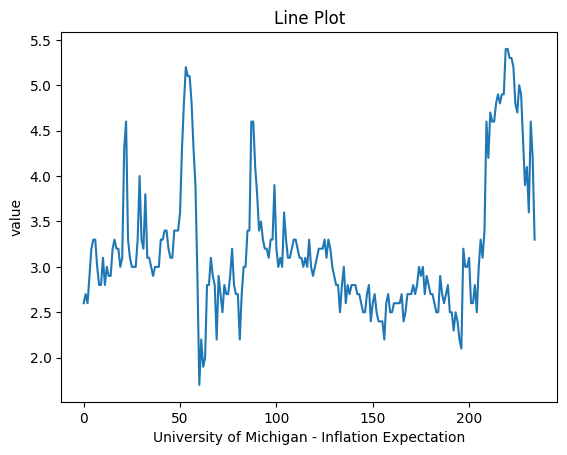

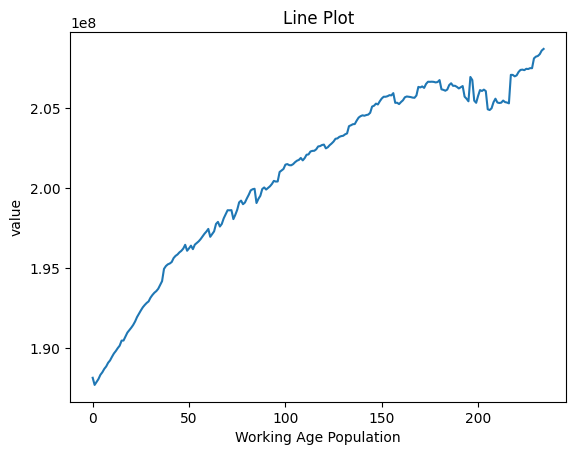

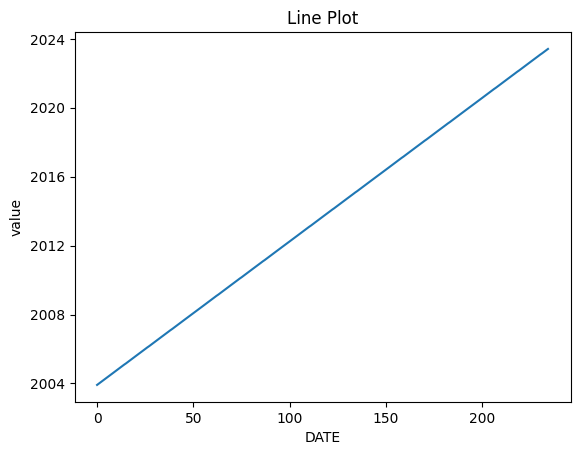

In [601]:

for column in data.columns:
    plt.plot(data.index, data[column], label=column)

    # plt.legend()
    # plt.tight_layout()  # Optional: Adjust the layout for better spacing
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
    plt.xlabel(column)
    plt.ylabel('value')
    plt.title('Line Plot')
    plt.show()

In [602]:
# from sklearn.ensemble import IsolationForest


# for column in data.columns:

#     plt.plot(data.index, data[column], c='red', label=column)

#     # Fit the IsolationForest model to detect outliers
#     outlier_detector = IsolationForest(contamination='auto', random_state=42)
#     outlier_detector.fit(data[[column]])

#     # Predict the outliers
#     data['is_outlier'] = outlier_detector.predict(data[[column]])

#     # Update the outlier values with a desired value (e.g., median)
#     median_value = data.loc[data['is_outlier'] == -1, column].median()
#     data.loc[data['is_outlier'] == -1, column] = median_value

#     # Remove the 'is_outlier' column since it's no longer needed
#     data.drop(columns='is_outlier', inplace=True)

#     plt.plot(data.index, data[column], c='blue', label=column+" updated")
#     plt.xlabel('Index')
#     plt.legend()
#     plt.ylabel(column)
#     plt.title(column + ' with Outliers vs Updated')

#     plt.tight_layout()
#     plt.show()


### <a id='toc1_2_5_'></a>[Drop index/periodDateUTC value](#toc0_)

there is no use of date anymore, order is preserved by index and it will create problem for observation since ```DATE``` is non-numeric value

In [603]:
data = data.drop('DATE', axis=1)

### <a id='toc1_2_6_'></a>[check simple correlation between features and Interest Rate](#toc0_)

The correlation coefficient ranges from -1 to 1:</br></br>

If the correlation coefficient is close to 1, it indicates a strong positive correlation, meaning that as one variable increases, the other tends to increase as well. </br>
If the correlation coefficient is close to -1, it indicates a strong negative correlation, meaning that as one variable increases, the other tends to decrease. </br>
If the correlation coefficient is close to 0, it indicates a weak or no linear correlation between the two variables.</br>

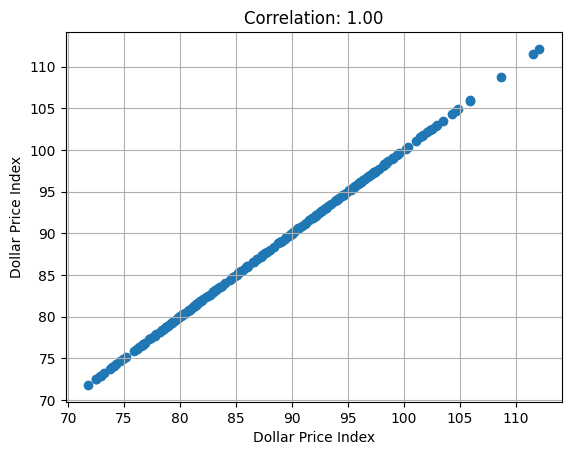

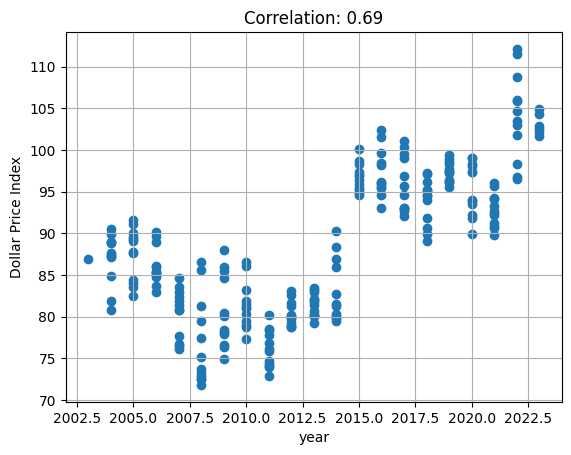

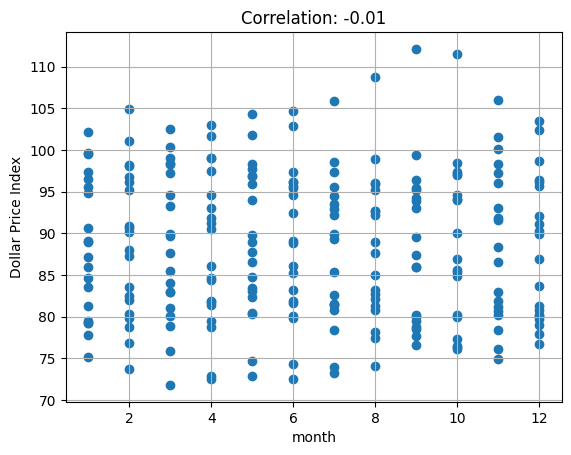

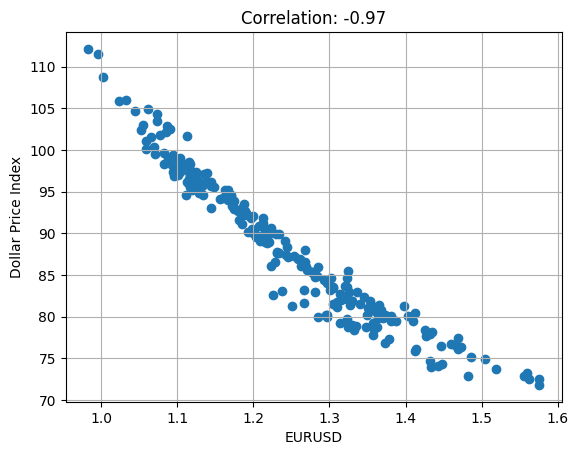

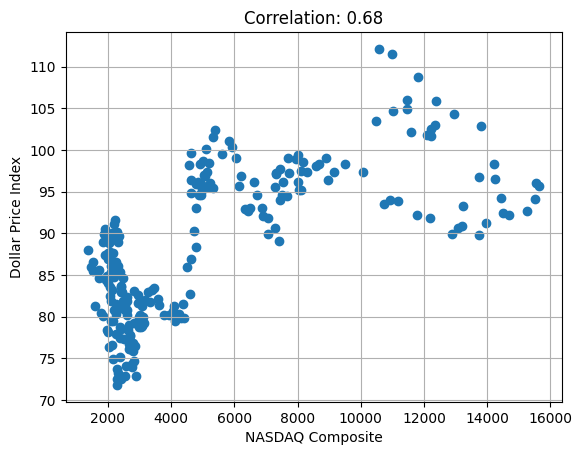

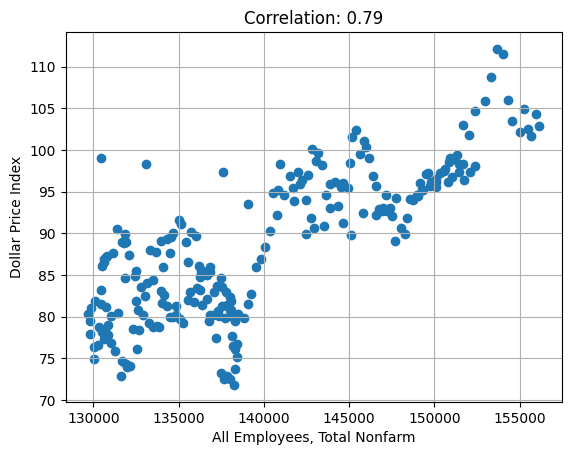

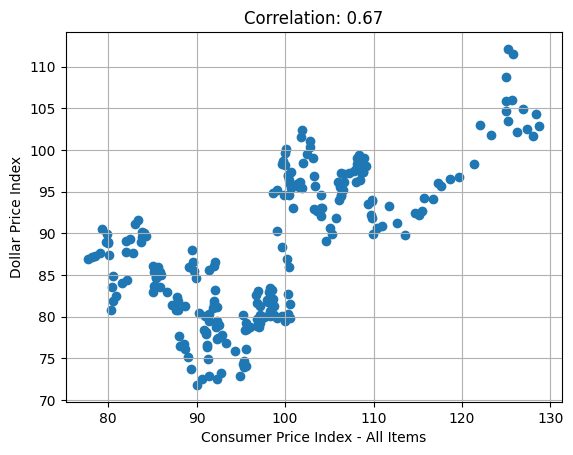

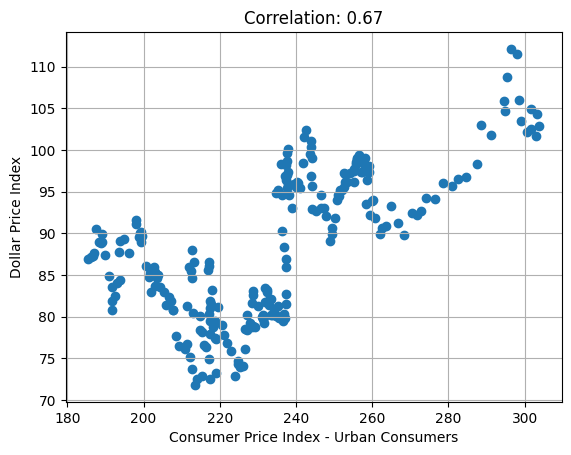

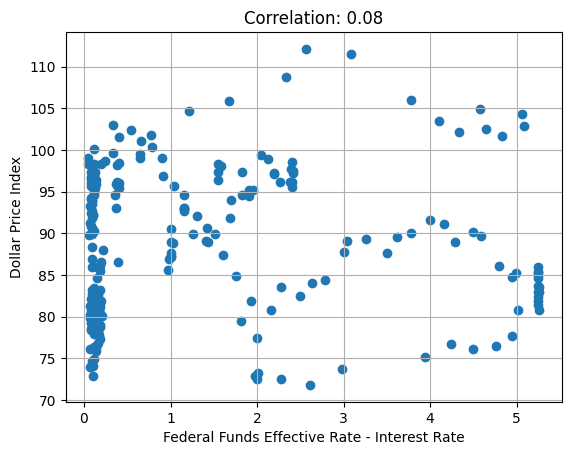

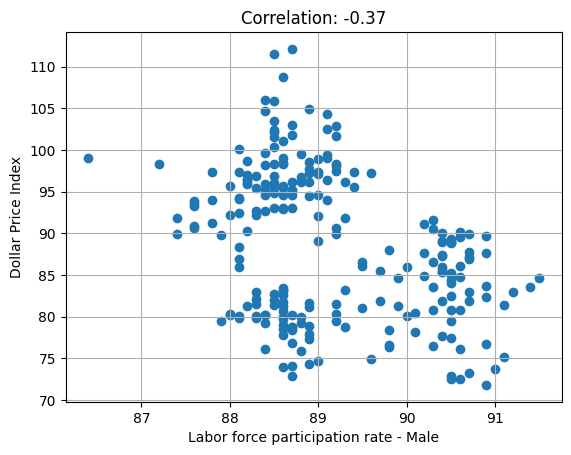

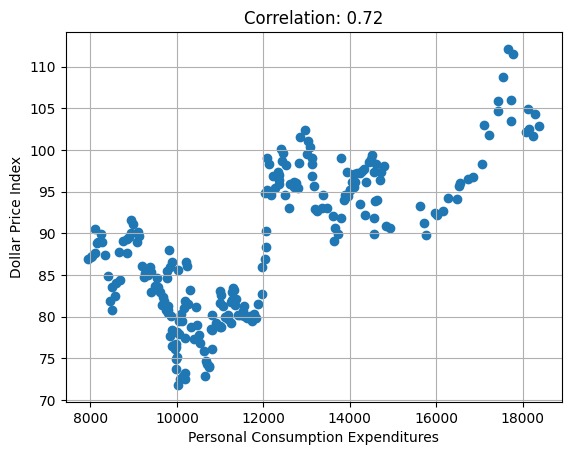

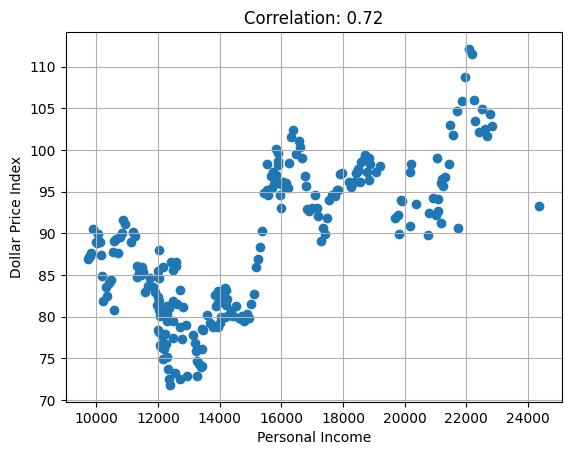

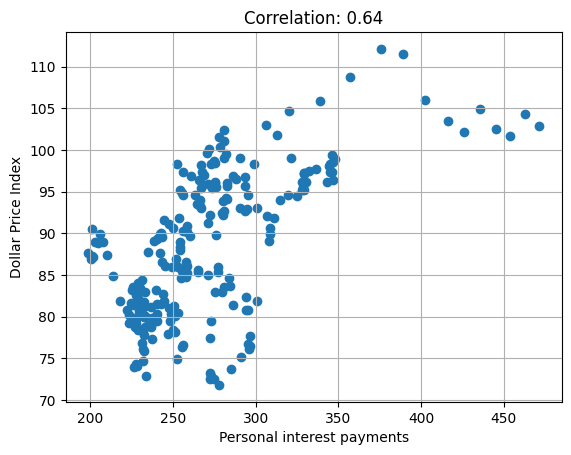

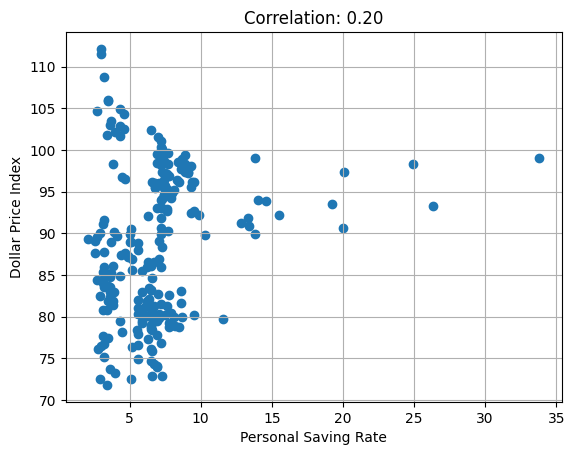

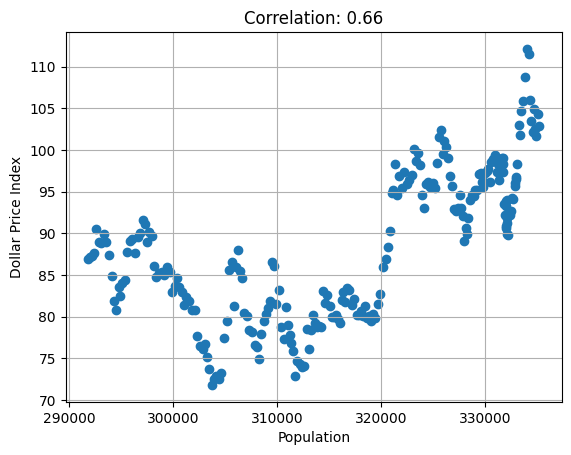

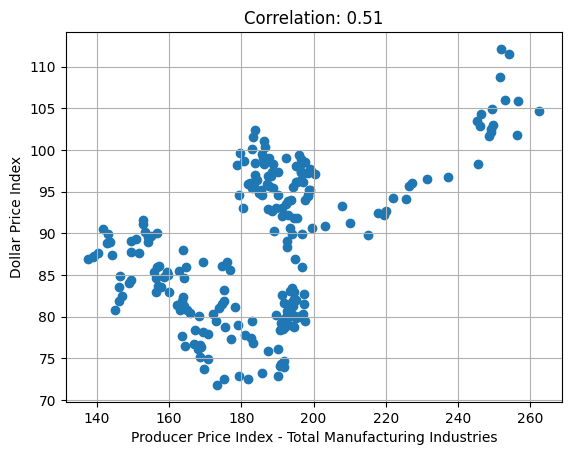

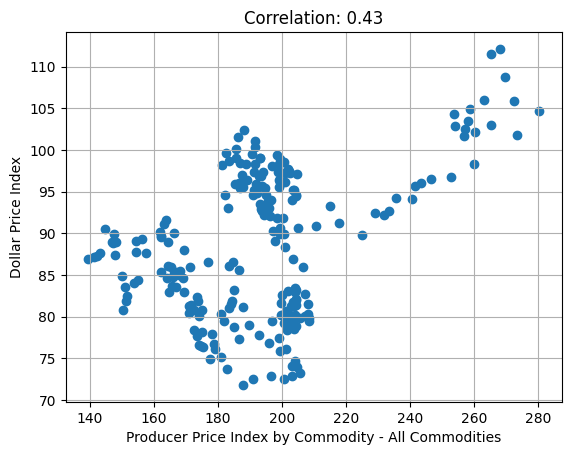

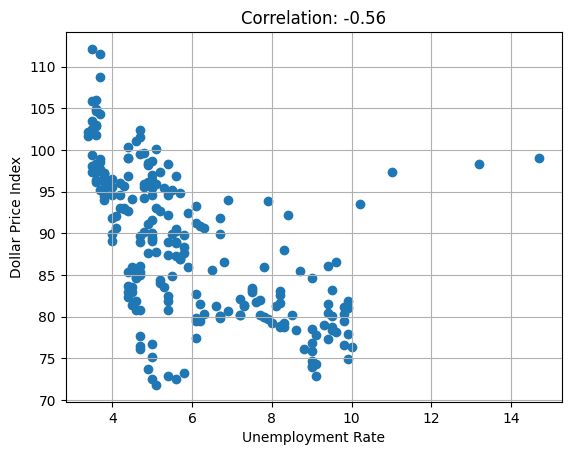

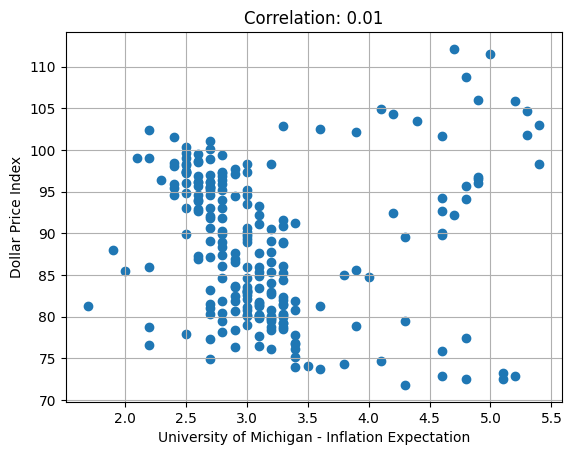

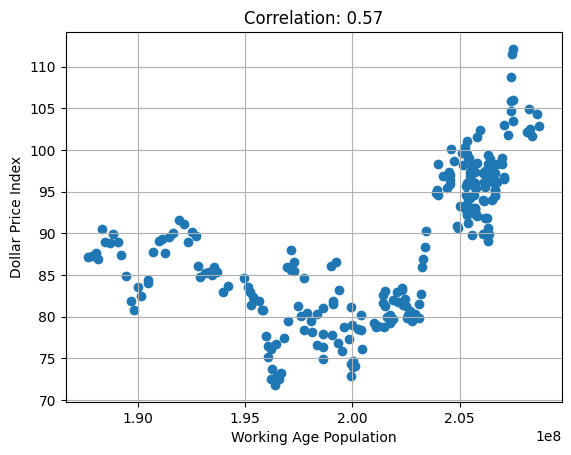

In [604]:
for column in data.columns:
    correlation = data[column].corr(data['Dollar Price Index'])

    # Plot a scatter plot to visualize the correlation
    plt.scatter(data[column], data['Dollar Price Index'])
    plt.xlabel(column)
    plt.ylabel('Dollar Price Index')
    plt.title(f'Correlation: {correlation:.2f}')
    plt.grid(True)
    plt.show()

### <a id='toc1_2_7_'></a>[check for correlation between all features](#toc0_)

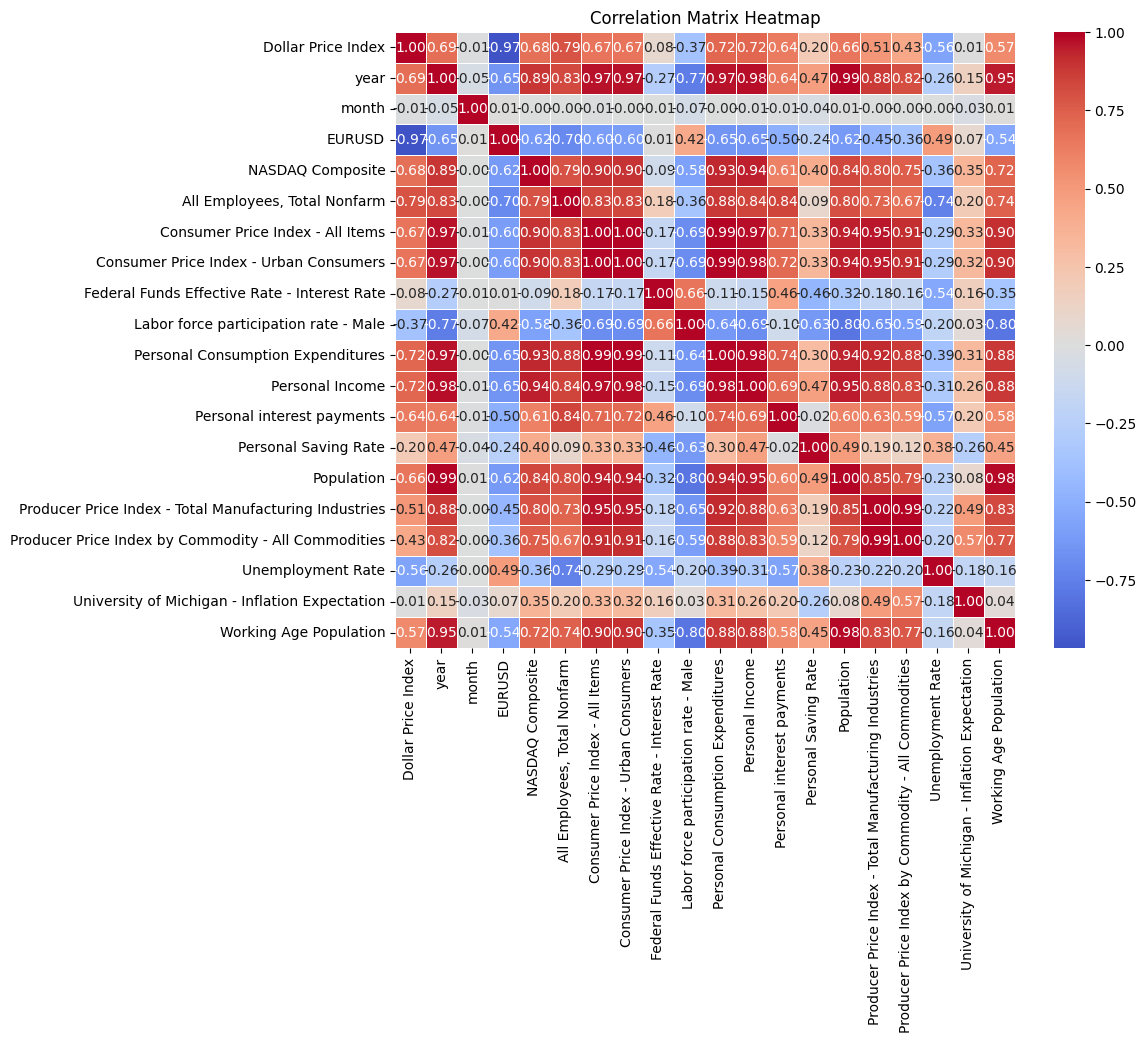

In [605]:
numeric_df = data.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

#### <a id='toc1_2_7_1_'></a>[find most correlted feature](#toc0_)

In [606]:
def getMulticollinearFeatures(df, threshold): 
    numeric_df = df.select_dtypes(include='number')
    correlation_matrix = numeric_df.corr()

    # Select highly correlated features
    multicollinear_features = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) >= threshold:
                colname_i = correlation_matrix.columns[i]
                colname_j = correlation_matrix.columns[j]
                multicollinear_features.append(colname_i)
                multicollinear_features.append(colname_j)

    return multicollinear_features;

In [607]:
def plotMulticollinearFeatures(features):
    multicollinear_features = np.array(features)
    string_counts = Counter(multicollinear_features)

    sorted_string_counts = dict(sorted(string_counts.items(), key=lambda x: x[1], reverse=False))
    plt.figure(figsize=(8, 6))
    plt.bar(sorted_string_counts.keys(), sorted_string_counts.values())
    plt.xlabel('multicollinear features')
    plt.ylabel('Frequency')
    plt.title('Distribution of Strings by Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#### <a id='toc1_2_7_2_'></a>[Variance Inflation Factor (VIF)](#toc0_)

<p>The Variance Inflation Factor (VIF) is a measure used to detect multicollinearity in a regression analysis. It quantifies how much the variance of the estimated regression coefficient is increased due to multicollinearity. High VIF values indicate high multicollinearity between predictor variables, which can affect the stability and interpretability of regression models.</p>

<p>VIF is a metric that quantifies the extent of multicollinearity in a feature by measuring how much the variance of an estimated regression coefficient increases when that feature is added to the model. </br>
High VIF values (>5 or 10) suggest the presence of multicollinearity.</P>

In [608]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def getVIF(df): 
    # Calculate VIF for each feature
    vif = pd.DataFrame()
    numeric_df = df.select_dtypes(include='number')
    vif['Feature'] = numeric_df.columns
    vif['VIF'] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]

    print(vif)

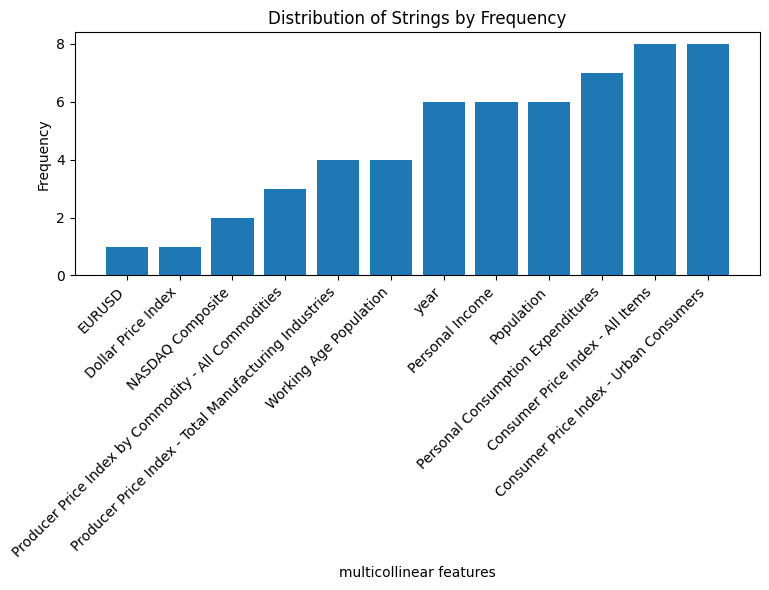

In [609]:
features = getMulticollinearFeatures(data, 0.9)
plotMulticollinearFeatures(features)


### <a id='toc1_2_8_'></a>[Feature Selection](#toc0_)

#### <a id='toc1_2_8_1_'></a>[Combine Feature which are highly correlated with each other from above figure](#toc0_)

In [610]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler


# # Standardize the data (mandatory for PCA)
# scaler = StandardScaler()

# ManufacturingCols = ['ISMManufacturing', 'ManufacturingNewOrdersIndex']
# #'ISMManufacturing', 'ManufacturingNewOrdersIndex', 'ManufacturingPricesPaid', 'ManufacturingEmploymentIndex',
# X_std = scaler.fit_transform(final_df[ManufacturingCols])

# # print(X_std)

# # Apply PCA to reduce the dimensionality to 1 component
# pca = PCA(n_components=1)
# X_pca = pca.fit_transform(X_std)

# # Add the reduced component as a new column in the DataFrame
# final_df['ISMManufacturing_PCA'] = X_pca

# cleaned_df = final_df.drop(ManufacturingCols,axis=1) # Independet variable

# features = getMulticollinearFeatures(cleaned_df, 0.8)
# plotMulticollinearFeatures(features)

In [611]:
getVIF(data);

                                              Feature            VIF
0                                  Dollar Price Index    7450.087645
1                                                year  283680.243182
2                                               month       5.017528
3                                              EURUSD    4496.181987
4                                    NASDAQ Composite     185.887825
5                        All Employees, Total Nonfarm  169647.678882
6                    Consumer Price Index - All Items  128277.884462
7              Consumer Price Index - Urban Consumers  114295.423283
8        Federal Funds Effective Rate - Interest Rate      18.150193
9               Labor force participation rate - Male  189573.932052
10                  Personal Consumption Expenditures   31273.566820
11                                    Personal Income   25174.740547
12                         Personal interest payments    1235.485590
13                               P

In [612]:
print(data.describe())

       Dollar Price Index         year       month      EURUSD  \
count          235.000000   235.000000  235.000000  235.000000   
mean            88.490085  2013.212766    6.446809    1.242794   
std              8.806576     5.672456    3.470317    0.127926   
min             71.800003  2003.000000    1.000000    0.982956   
25%             80.959999  2008.000000    3.000000    1.127195   
50%             88.360001  2013.000000    6.000000    1.229990   
75%             95.919998  2018.000000    9.000000    1.331266   
max            112.120003  2023.000000   12.000000    1.575796   

       NASDAQ Composite  All Employees, Total Nonfarm  \
count        235.000000                    235.000000   
mean        5300.130388                 140050.689362   
std         3811.888266                   7396.034498   
min         1377.839966                 129700.000000   
25%         2332.670044                 133881.000000   
50%         3771.479980                 138038.000000   
75%   

### <a id='toc1_2_9_'></a>[Spliting data](#toc0_)

In [613]:
from sklearn.model_selection import train_test_split
target = 'Dollar Price Index'
# target = 'Federal Funds Effective Rate - Interest Rate'
test_size = 0.2
metrics = {'R-squared': {}, 'Mean Squared Error': {}, 'Residual Mean': {}, 'Predictions': {}}


X = data.drop(target,axis=1) # Independet variable
y = data[target] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=23)

# # Split data into training and test sets
# train_size = int(test_size * len(data))
# train_data, test_data = data[:train_size], data[train_size:]

# # Prepare the features (X) and target variable (y) for training and testing
# X_train = train_data.drop(target,axis=1)
# y_train = train_data[target]
# X_test = test_data.drop(target,axis=1)
# y_test = test_data[target]

### <a id='toc1_2_10_'></a>[Bios Calculation](#toc0_)

In [614]:
# Step 1: add x0 =1 to dataset
X_train_0 = np.c_[np.ones((X_train.shape[0],1)),X_train]
X_test_0 = np.c_[np.ones((X_test.shape[0],1)),X_test]

# Step2: build model
theta = np.matmul(np.linalg.inv( np.matmul(X_train_0.T,X_train_0) ), np.matmul(X_train_0.T,y_train)) 

In [615]:
# The parameters for linear regression model
parameter = ['theta_'+str(i) for i in range(X_train_0.shape[1])]
columns = ['intersect:x_0=1'] + list(X.columns.values)
parameter_df = pd.DataFrame({'Parameter':parameter,'Columns':columns,'theta':theta})

This process essentially calculates the coefficients (parameters) for each feature, including the bias term, in the linear regression model. The resulting DataFrame parameter_df provides a clear representation of the model's parameters and their relationship with the features.

### <a id='toc1_2_11_'></a>[Linear Regression](#toc0_)

In [616]:
# Scikit Learn module
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train) # Note: x_0 =1 is no need to add, sklearn will take care of it.

#Parameter
sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
parameter_df = parameter_df.join(pd.Series(sk_theta, name='Sklearn_theta'))
parameter_df

,Parameter,Columns,theta,Sklearn_theta
0,theta_0,intersect:x_0=1,-2.888315e+02,-2.888316e+02
1,theta_1,year,2.728697e-01,2.728697e-01
2,theta_2,month,5.294526e-02,5.294526e-02
3,theta_3,EURUSD,-5.198937e+01,-5.198937e+01
4,theta_4,NASDAQ Composite,-7.406515e-04,-7.406515e-04
5,theta_5,"All Employees, Total Nonfarm",3.685197e-04,3.685197e-04
6,theta_6,Consumer Price Index - All Items,7.151002e-01,7.151002e-01
7,theta_7,Consumer Price Index - Urban Consumers,-8.575009e-02,-8.575008e-02
8,theta_8,Federal Funds Effective Rate - Interest Rate,-8.190135e-01,-8.190135e-01
9,theta_9,Labor force participation rate - Male,-3.679008e-01,-3.679008e-01


In [617]:
# Normal equation
y_pred_norm =  np.matmul(X_test_0,theta)

#Evaluvation: MSE
J_mse = np.sum((y_pred_norm - y_test)**2)/ X_test_0.shape[0]

# R_square 
sse = np.sum((y_pred_norm - y_test)**2)
sst = np.sum((y_test - y_test.mean())**2)
R_square = 1 - (sse/sst)
print('The Mean Square Error(MSE) or J(theta) is: ',J_mse)
print('R square obtain for normal equation method is :',R_square)

The Mean Square Error(MSE) or J(theta) is:  1.3516293442861185
R square obtain for normal equation method is : 0.984050683495053


In [618]:
# sklearn regression module
y_pred_sk = lin_reg.predict(X_test)

#Evaluvation: MSE
from sklearn.metrics import mean_squared_error
J_mse_sk = mean_squared_error(y_pred_sk, y_test)

# R_square
R_square_sk = lin_reg.score(X_test,y_test)
print('The Mean Square Error(MSE) or J(theta) is: ',J_mse_sk)
print('R square obtain for scikit learn library is :',R_square_sk)

The Mean Square Error(MSE) or J(theta) is:  1.3516291456392557
R square obtain for scikit learn library is : 0.9840506858390993


C:\Users\ACER\AppData\Local\Temp\ipykernel_37568\2482664790.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - y_pred_sk),ax=ax,color='b')


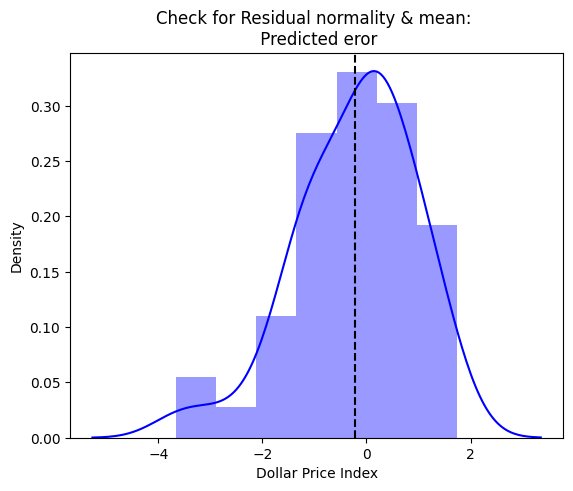

In [619]:
# Check for Linearity
f = plt.figure(figsize=(14,5))

# sns.scatterplot(y_test,y_pred_sk,ax=ax,color='r')
# sns.scatterplot(x=y_test,y=y_pred_sk, color='r')
# sns.scatterplot(data = ax, color='b')


# ax.set_title('Check for Linearity:\n Unemployed Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred_sk),ax=ax,color='b')
ax.axvline((y_test - y_pred_sk).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Predicted eror');

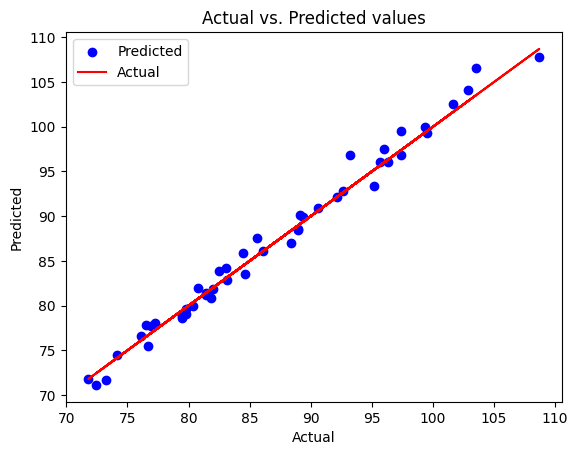

In [620]:
# Plot actual vs. predicted values in different colors
plt.scatter(y_test, y_pred_sk, color='blue', label='Predicted')
plt.plot(y_test, y_test, color='red', label='Actual')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted values")
plt.legend()
plt.show()

### <a id='toc1_2_12_'></a>[Multivariate Normality and Homoscedasticity](#toc0_)

In [621]:
# # Check for Multivariate Normality
# # Quantile-Quantile plot 
# plt.figure(figsize=(8, 6))
# _,(_,_,r)= sp.stats.probplot((y_test - y_pred_sk),fit=True,plot=plt)
# plt.title('Check for Multivariate Normality: Q-Q Plot')
# plt.legend().set_visible(False)  # Hide the legend
# plt.show()

# # Calculate the residuals
# residuals = y_test - y_pred_sk

# # Create the plot with different colors for actual and predicted values
# plt.figure(figsize=(8, 6))
# sns.scatterplot(y=residuals, x=y_pred_sk, hue=residuals, palette='coolwarm', alpha=0.7)
# plt.axhline(0, color='gray', linestyle='dashed')  # Add a dashed line at y=0 for reference
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals (Actual - Predicted)')
# plt.title('Homoscedasticity: Original Vs. Predicted: (Residuals Plot)')
# plt.legend()
# plt.show()

In [622]:
# Check for Multicollinearity
#Variance Inflation Factor
VIF = 1/(1- R_square_sk)

### <a id='toc1_2_13_'></a>[r2 score and mean squared error](#toc0_)

The Mean Squared Error (MSE) indicates the average squared difference between the predicted values and the actual values in your regression model. A lower MSE value indicates better model performance, as it means the model's predictions are closer to the actual values.

The formula for calculating MSE is:

�
�
�
=
1
�
∑
�
=
1
�
(
�
�
−
�
^
�
)
2
MSE= 
n
1
​
 ∑ 
i=1
n
​
 (y 
i
​
 − 
y
^
​
  
i
​
 ) 
2
 

Where:

�
n is the number of samples in the test set.
�
�
y 
i
​
  is the actual value for the 
�
ith sample.
�
^
�
y
^
​
  
i
​
  is the predicted value for the 
�
ith sample.

In [623]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred_sk)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
r2 = r2_score(y_test, y_pred_sk)
print("Root Squared Error:", r2)

accuracy = pd.DataFrame();
accuracy['test'] = y_test
accuracy['prediction'] = y_pred_sk

residuals = 100 - abs((y_test - y_pred_sk) * 100/ y_test)
accuracy['residuals_pct'] = residuals


residual_mean = np.mean(residuals)
residual_std = np.std(residuals)

accuracy['residuals_mean'] = residual_mean
print("Mean of Residuals / Accouracy :", residual_mean)


metrics['R-squared']['Linear Regression'] = r2
metrics['Mean Squared Error']['Linear Regression'] = mse
metrics['Residual Mean']['Linear Regression'] = residual_mean
metrics['Predictions']['Linear Regression'] = y_pred_sk

Mean Squared Error: 1.3516291456392557
Root Squared Error: 0.9840506858390993
Mean of Residuals / Accouracy : 98.97990136114447


### <a id='toc1_2_14_'></a>[SVR (Support Vector Regression)](#toc0_)

In [624]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [625]:
X = data.drop(target,axis=1) # Independet variable
y = data[target] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=23)

# # Split data into training and test sets
# train_size = int(test_size * len(data))
# train_data, test_data = data[:train_size], data[train_size:]

# # Prepare the features (X) and target variable (y) for training and testing
# X_train = train_data.drop(target,axis=1)
# y_train = train_data[target]
# X_test = test_data.drop(target,axis=1)
# y_test = test_data[target]


# Standardize the features (optional but can improve model performance)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the SVR model
svr = SVR(kernel='linear')
svr.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svr.predict(X_test_scaled)

### <a id='toc1_2_15_'></a>[Accuracy of SVR](#toc0_)

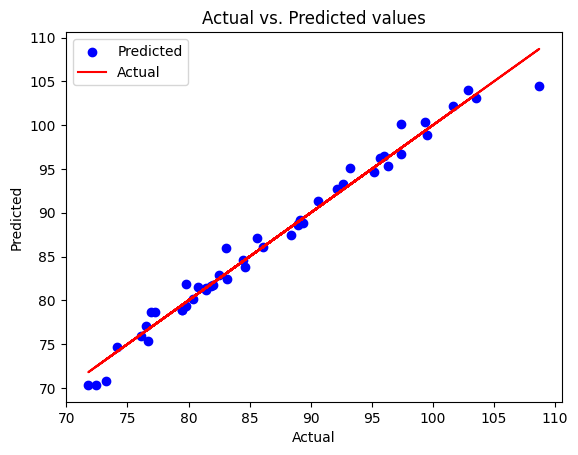

In [626]:
# Plot actual vs. predicted values in different colors
plt.scatter(y_test, y_pred, color='blue', label='Predicted')
plt.plot(y_test, y_test, color='red', label='Actual')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted values")
plt.legend()
plt.show()

In [627]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
r2 = r2_score(y_test, y_pred)
print("Root Squared Error:", r2)

accuracy = pd.DataFrame();
accuracy['test'] = y_test
accuracy['prediction'] = y_pred

residuals = 100 - abs((y_test - y_pred) * 100/ y_test)
accuracy['residuals_pct'] = residuals

residual_mean = np.mean(residuals)
residual_std = np.std(residuals)

accuracy['residuals_mean'] = residual_mean
print("Mean of Residuals / Accouracy :", residual_mean)


metrics['R-squared']['SVR'] = r2
metrics['Mean Squared Error']['SVR'] = mse
metrics['Residual Mean']['SVR'] = residual_mean
metrics['Predictions']['SVR'] = y_pred

Mean Squared Error: 1.570350938651321
Root Squared Error: 0.9814697540784608
Mean of Residuals / Accouracy : 98.93974830260439


### <a id='toc1_2_16_'></a>[Random Forest Regression:](#toc0_)

In [628]:
from sklearn.ensemble import RandomForestRegressor

X = data.drop(target,axis=1) # Independet variable
y = data[target] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=23)
# # Split data into training and test sets
# train_size = int(test_size * len(data))
# train_data, test_data = data[:train_size], data[train_size:]

# # Prepare the features (X) and target variable (y) for training and testing
# X_train = train_data.drop(target,axis=1)
# y_train = train_data[target]
# X_test = test_data.drop(target,axis=1)
# y_test = test_data[target]

# Create a Random Forest Regressor model
# We'll use 10 decision trees in the ensemble
model = RandomForestRegressor(n_estimators=100, random_state=23)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the target values for the test data
y_pred = model.predict(X_test)

##### <a id='toc1_2_16_1_1_'></a>[Accuracy of RFR](#toc0_)

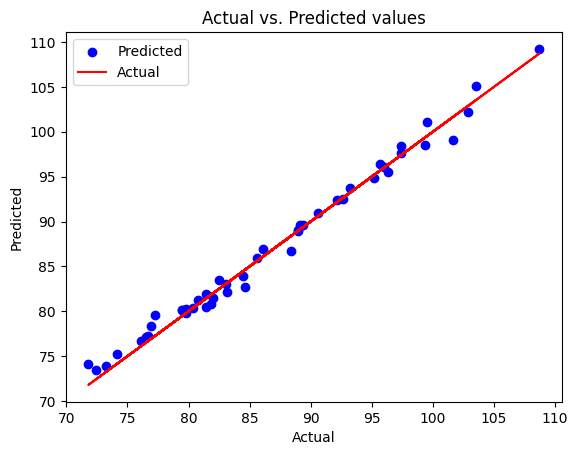

In [629]:
# Plot actual vs. predicted values in different colors
plt.scatter(y_test, y_pred, color='blue', label='Predicted')
plt.plot(y_test, y_test, color='red', label='Actual')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted values")
plt.legend()
plt.show()

In [630]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
r2 = r2_score(y_test, y_pred)
print("Root Squared Error:", r2)

accuracy = pd.DataFrame();
accuracy['test'] = y_test
accuracy['prediction'] = y_pred

residuals = 100 - abs((y_test - y_pred) * 100/ y_test)
accuracy['residuals_pct'] = residuals

residual_mean = np.mean(residuals)
residual_std = np.std(residuals)

accuracy['residuals_mean'] = residual_mean
print("Mean of Residuals / Accouracy :", residual_mean)


metrics['R-squared']['Random Forest Regression'] = r2
metrics['Mean Squared Error']['Random Forest Regression'] = mse
metrics['Residual Mean']['Random Forest Regression'] = residual_mean
metrics['Predictions']['Random Forest Regression'] = y_pred


Mean Squared Error: 0.992586664946323
Root Squared Error: 0.9882874110829696
Mean of Residuals / Accouracy : 99.08382198740563


### <a id='toc1_2_17_'></a>[Conclusion](#toc0_)

compairing values of all 3 algorithms

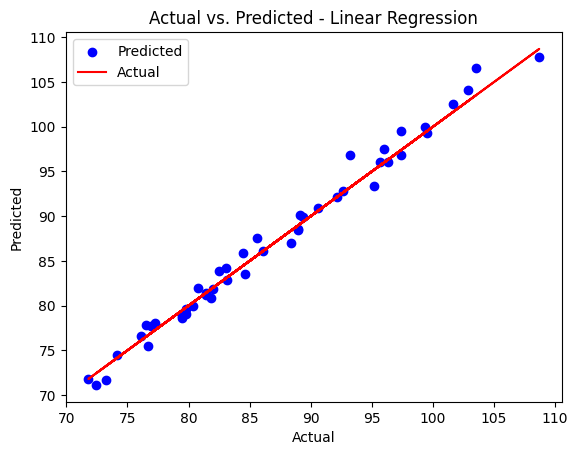

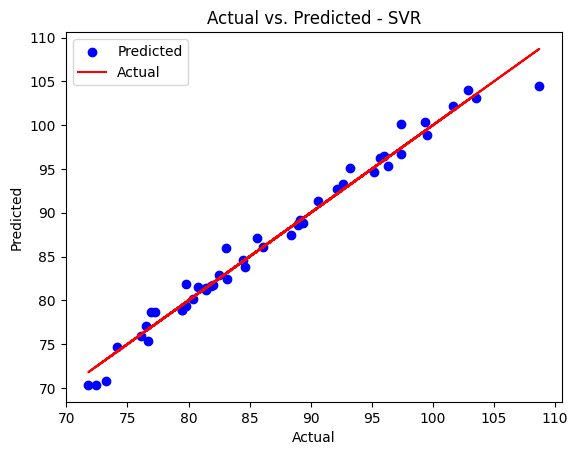

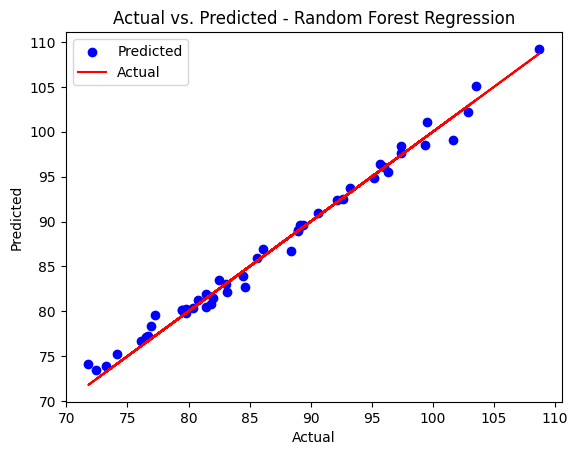

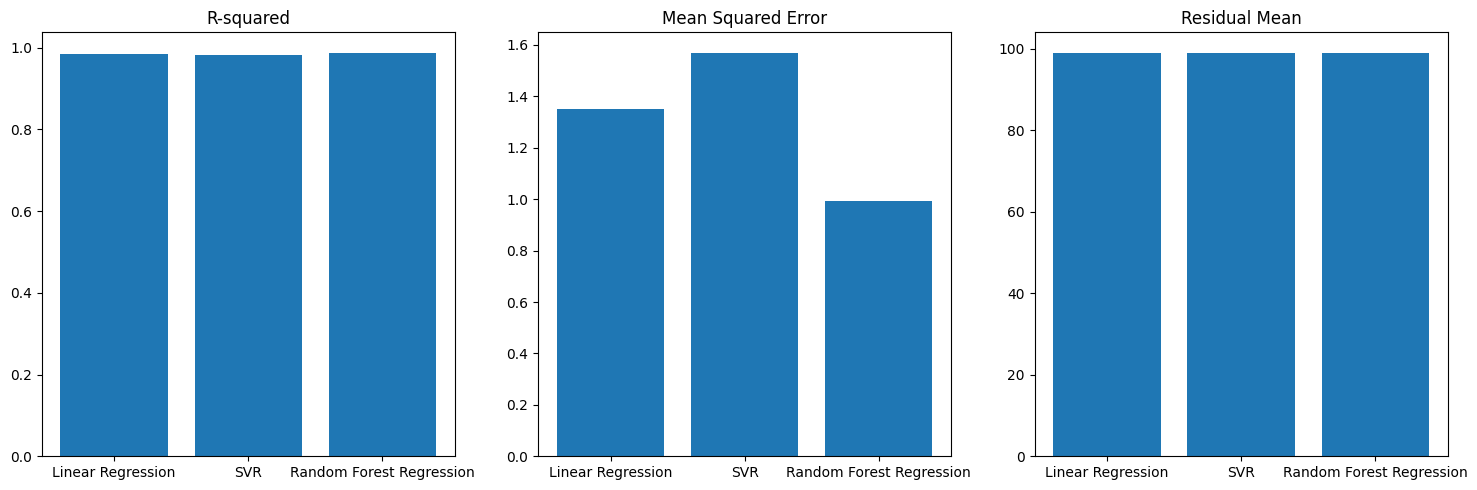

In [631]:
# Print the results
for metric_name, metric_values in metrics.items():
    model_name = metric_name
    for model_name, value in metric_values.items():
        if metric_name == 'Predictions':
            # Plot actual vs. predicted values in different colors
            plt.scatter(y_test, value, color='blue', label='Predicted')
            plt.plot(y_test, y_test, color='red', label='Actual')
            plt.xlabel("Actual")
            plt.ylabel("Predicted")
            plt.title("Actual vs. Predicted - " + model_name)
            plt.legend()
            plt.show()


# Extract metric values for each model
model_names = list(metrics['R-squared'].keys())
r2_scores = list(metrics['R-squared'].values())
mse_scores = list(metrics['Mean Squared Error'].values())
residual_means = list(metrics['Residual Mean'].values())

# Create bar plots for the evaluation metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(model_names, r2_scores)
plt.title('R-squared')

plt.subplot(1, 3, 2)
plt.bar(model_names, mse_scores)
plt.title('Mean Squared Error')

plt.subplot(1, 3, 3)
plt.bar(model_names, residual_means)
plt.title('Residual Mean')

plt.tight_layout()
plt.show()

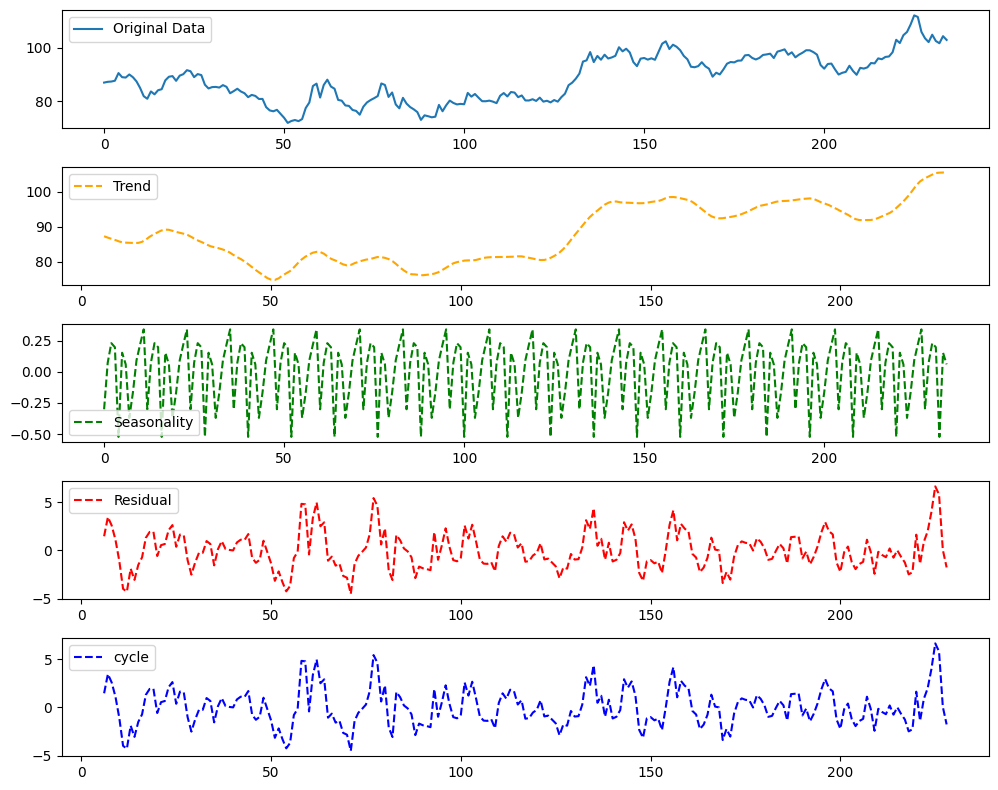

In [632]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform time series decomposition
result = seasonal_decompose(data[target], model='additive', period=12)

# Calculate the cycle component by subtracting trend and seasonality from the original data
cycle = data[target] - result.trend - result.seasonal

# Plot the components
plt.figure(figsize=(10, 8))
plt.subplot(5, 1, 1)
plt.plot(data.index, data[target], label='Original Data')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(data.index, result.trend, label='Trend', linestyle='dashed', color='orange')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(data.index, result.seasonal, label='Seasonality', linestyle='dashed', color='green')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(data.index, result.resid, label='Residual', linestyle='dashed', color='red')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(data.index, cycle, label='cycle', linestyle='dashed', color='blue')
plt.legend()

plt.tight_layout()
plt.show()